# Building a Neural Network for Image Classification: A Step-by-Step Guide

Image classification is one of the fundamental deep learning tasks. While modern frameworks like PyTorch, JAX, Keras, and TensorFlow offer a convenient abstraction to build and train neural networks, crafting one from scratch provides a more comprehensive understanding of the nuances involved.

In this notebook, we will implement in Python the essential modules required to build and train a multilayer perceptron that classifies garment images. In particular, we will delve into the fundamentals of approximation, non-linearity, regularization, optimizers, gradients, and backpropagation. Additionally, we explore the significance of random parameter initialization and the benefits of training in mini-batches.

By the end, you will be able to construct the fundamental building blocks of a neural network from scratch, understand how it learns, and deploy it to HuggingFace to classify real-world garment images.

### The Intuition behind our Neural Network

Our goal is to classify garment images by approximating a large mathematical function to a training dataset of such images. We will begin this process by randomly initializing the parameters of our function, and adjusting them to combine input pixel values, until we obtain favorable outputs in form of class predictions. This iterative method seeks to learn features in the training dataset that differentiate between classes.

The foundation for this approach lies in the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), a fundamental concept that highlights the combination of linear transformations and non-linear functions to approximate complex patterns, such as those needed for computer vision.

The principle of teaching computers through examples, rather than explicit programming, dates back to Arthur Samuel in 1949 [1]. Samuel suggested the concept of using weights as function parameters that can be adjusted to influence a program’s behavior and outputs. And emphasized the idea of automating such a method that tests and optimizes these weights based on their performance in real tasks.

We will then implement a method to adjust weights automatically, applying [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) [2] in mini-batches. In practice, this involves the following steps:

1. Initialize weights and bias parameters.
2. Calculate predictions on a *mini-batch*.
3. Calculate the average loss between the predictions and the targets.
4. Calculate the *gradients* to get an indication of how the parameters need to change to minimize the loss.
5. Update the weights and bias parameters based on the gradients and a learning rate.
6. Repeat from step 2.
7. Stop the process once a condition is met, such as a time constraint or when the training/validation losses and metrics cease to improve.

***A mini-batch refers to a randomly selected subset of the training dataset** that is used to calculate the loss and update the weights in each iteration. The benefits of training in mini-batches are explained in the Training section*.

***Gradients** are a measure inferred from the derivative of a function that signals how the output of the function would change by modifying its parameters. Within the context of neural networks, they represent a vector that **indicates the direction and magnitude in which we need to change each weight to improve our model**.*

--------

### Architecture

In the following sections, we dive into the implementation details of the required components to build and train our multilayer perceptron. For simpler integration with advanced functionality such as gradient computation, these components will be defined as custom PyTorch modules.

#### Linear Layer

At the heart of our neural network are linear functions. These functions perform two key operations: (i) transformation of input values by their weights and bias parameters through matrix multiplication, and (ii) dimensionality reduction (or augmentation in some cases).

The transformation operation projects input values into a different space, which along the use of stacked linear layers, enables the network to progressively learn more abstract and complex patterns. Dimensionality reduction is achieved when the number of output units in a linear layer is smaller than the number of inputs. This compression forces the layer to capture the most salient features of the higher-dimensional input.

In [1]:
import torch
import torch.nn as nn

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [2]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, std: float = 0.1):
        """
        Initialize a linear layer with random weights.

        Weights and biases are registered as parameters, allowing for 
        gradient computation and update during backpropagation.
        """
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        weight = torch.randn(in_features, out_features, requires_grad=True) * std
        bias = torch.zeros(out_features, requires_grad=True)
        
        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)
        self.to(device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform linear transformation by multiplying the input tensor
        with the weight matrix, and adding the bias.
        """
        return x @ self.weight + self.bias

    def __repr__(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

Note that **the weights are randomly initialized  according to a Gaussian distribution (`randn`) to break symmetry and enable effective learning**. If all parameters were first set to the same value, such as zeros, they will compute the same gradients during backpropagation, leading to identical weight updates and slower (or non)convergence.

Furthermore, **scaling weights is also a common practice in initialization**. This helps in controlling the variance, and can have a big impact on the training dynamics. We favour a relatively small scale value (`std=0.1`) since large values might lead to gradients increasing exponentially (and overflowing to NaN) during backpropagation, resulting in the *exploding gradients problem*.

#### Introducing non-linearity

Without non-linearity, no matter how many layers our neural network has, it would still behave like a single-layer perceptron. This is due to the fact that the composition of successive linear transformations is itself another linear transformation, which would prevent the model from approximating complex patterns.

To overcome this limitation, we adhere to the Universal Approximation Theorem and introduce non-linearity by implementing the Rectified Linear Unit (ReLU), a widely used and effective activation function that sets negative values to zero while preserving positive values. 

In [3]:
class ReLU(nn.Module):
    """
    Rectified Linear Unit (ReLU) activation function.
    """

    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return torch.clip(x, 0.)

The Rectified Linear Unit (ReLU) was proposed by Kunihiko Fukushima in 1969 within the context of visual feature extraction in hierarchical neural networks [3]. In 2011 [4], it was found to enable better training of deeper networks compared to the widely used activation functions *logistic sigmoid* and *hyperbolic tangent*.

#### Regularization

Regularization is a fundamental technique used to reduce *overfitting* in neural networks, which occurs when parameters become tuned to noise on invidual data points during training. A widely used and effective method of regularization is the *dropout* function, introduced by G. Hinton's research group in 2014 [5]. Dropout works by randomly deactivating a portion of the network's units during the training phase. This encourages each unit to contribute independently, preventing the model from becoming overly reliant on over-specialized single units and enhancing its ability to generalize to new data.

In [4]:
class Dropout(nn.Module):
    """
    Applies the dropout regularization technique to the input tensor.

    During training, it randomly sets a fraction of input units to 0 with probability `p`,
    scaling the remaining values by `1 / (1 - p)` to maintain the same expected output sum.
    During evaluation, no dropout is applied.
    """

    def __init__(self, p=0.2):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            mask = (torch.rand(x.shape) > self.p).float().to(x) / (1 - self.p)
            return x * mask
        return x

#### Flatten Transformation

In deep learning, flattening images is necessary to convert multi-dimensional data into a one-dimensional (1D) array before feeding it into a classification model. Our training dataset, Fashion MNIST [6], is a collection of 60,000 grayscale images of size 28x28. We include a transformation to flatten these images in their width and height dimensions to reduce memory usage (multi-dimensional arrays take up additional memory overhead to manage their structure), and simplify the input for the model (each pixel becomes an individual unit).

In [5]:
class Flatten(nn.Module):
    """
    Reshape the input tensor by flattening all dimensions except the first dimension.
    """

    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        """
        x.view(x.size(0), -1) reshapes the x tensor to (x.size(0), N)
        where N is the product of the remaining dimensions.
        E.g. (batch_size, 28, 28) -> (batch_size, 784)
        """
        return x.view(x.size(0), -1)

#### Sequential Layer

To construct the full neural network architecture, we need a way to connect the individual linear operations and activation functions in a sequential manner, forming a feedforward path from the inputs to the outputs. This is achieved by using a sequential layer, which allows to define the specific order and composition of the various layers in our network.

In [6]:
class Sequential(nn.Module):
    """
    Sequential container for stacking multiple modules,
    passing the output of one module as input to the next.
    """

    def __init__(self, *layers):
        super(Sequential, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self) -> str:
        layer_str = '\n'.join([f' ({i}): {layer}' for i, layer in enumerate(self.layers)])
        return f'{self.__class__.__name__}(\n{layer_str}\n)'

#### Classifier Model

After flattening the input images, we stack linear operations with non-linear functions, enabling the network to learn hierarchical representations and patterns in the data. This is essential for our image classification task, where the network needs to capture visual features to distinguish between various classes.

In [7]:
class Classifier(nn.Module):
    """
    Classifier model consisting of a sequence of linear layers and ReLU activations,
    followed by a final linear layer that outputs logits (unnormalized scores)
    for each of the 10 garment classes.

    It encapsulates also a method to convert logits into a label/probability dict.
    """

    def __init__(self):
        """
        The output logits of the last layer can be passed directly to
        a loss function like CrossEntropyLoss, which will apply the 
        softmax function internally to calculate a probability distribution.
        """
        super(Classifier, self).__init__()
        self.labels = ['T-shirt/Top', 'Trouser/Jeans', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-Boot']
        
        self.main = Sequential(
            Flatten(),
            Linear(in_features=784, out_features=256),
            ReLU(),
            Dropout(0.2),
            Linear(in_features=256, out_features=64),
            ReLU(),
            Dropout(0.2),
            Linear(in_features=64, out_features=10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)
    
    def predictions(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.nn.functional.softmax(logits, dim=1)
            predictions = dict(zip(self.labels, probs.cpu().detach().numpy().flatten()))    
        return predictions

In [8]:
model = Classifier().to(device)
model

Classifier(
  (main): Sequential(
   (0): Flatten()
   (1): in_features=784, out_features=256, bias=True
   (2): ReLU()
   (3): Dropout()
   (4): in_features=256, out_features=64, bias=True
   (5): ReLU()
   (6): Dropout()
   (7): in_features=64, out_features=10, bias=True
  )
)

Verify that the parameters have been properly registered.

In [9]:
list(model.parameters())[0]

Parameter containing:
tensor([[-0.0203,  0.1397,  0.0477,  ...,  0.0906,  0.0622,  0.0815],
        [-0.1574,  0.1081,  0.1400,  ...,  0.2015, -0.0745, -0.0486],
        [ 0.0043,  0.0294,  0.0901,  ...,  0.0630,  0.0325, -0.0345],
        ...,
        [-0.0585, -0.0547, -0.0373,  ...,  0.0617, -0.0377,  0.0973],
        [-0.0604, -0.1268,  0.0567,  ..., -0.0849,  0.0295, -0.0989],
        [-0.0091, -0.0138,  0.1573,  ...,  0.1965,  0.0552, -0.1431]],
       device='cuda:0', requires_grad=True)

#### Gradient Descent Optimizer

We implement a basic optimizer to automatically adjust the neural network’s parameters, weights and biases, based on gradients. Computed during backpropagation, gradients indicate how to update these parameters to minimize the loss function. Using these gradients, the optimizer updates the parameters in a stepwise manner, with the step size determined by the learning rate.

In [10]:
class Optimizer:
    """
    Update model parameters during training.
    
    It performs a simple gradient descent step by updating the parameters
    based on their gradients and the specified learning rate (lr).
    """

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self):
        """
        Reset the gradients of all parameters to zero.
        Since PyTorch accumulates gradients, this method ensures that
        the gradients from previous optimization steps do not interfere
        with the current step.
        """
        for p in self.params:
            p.grad = None

#### Backpropagation

Introduced by [Paul Werbos](https://ieeexplore.ieee.org/author/37344537300) in 1974 [8], the concept of backpropagation for neural networks was almost entirely ignored for decades. However, it is nowadays recognized as one of the most important AI foundations.

At its core, backpropagation serves to calculate the gradients of the loss function with respect to each parameter in the network. This is achieved by applying the [chain rule of calculus](https://en.wikipedia.org/wiki/Chain_rule), systematically calculating these gradients from the output layer back to the input layer — hence the term *backpropagation*.

Under the hood, this method involves computing partial derivatives of a complex function, and maintaining a directed acyclic graph (DAG) that tracks the sequence of operations on the input data. To simplify this task, modern frameworks like PyTorch provide an automatic differentiation tool known as [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). In practice, as in the implementation of the *Linear transformation*, setting `requires_grad = True` is the main way to control which parts of the model are to be tracked and included in the gradient computation.

#### Init Config

Feel free to experiment with different learning rates and batch sizes (32, 64, 128). Keep in mind that if the batch size is too large, it might exceed the GPU's memory capacity, causing an out-of-memory error.

In [11]:
from dataclasses import dataclass

@dataclass
class LearnerConfig:
    """
    Configuration class for the Learner.

    This class holds the hyperparameters and settings for training the model.
    """

    model: nn.Module
    criterion: nn.Module
    epochs: int
    batch_size: int
    lr: float
    device: str

# Example configuration
config = LearnerConfig(
    model=model,
    criterion=nn.CrossEntropyLoss(),
    epochs=25,
    batch_size=32,
    lr=0.005,
    device=device,
)

--------

## Training

#### The Fashion Dataset

Fashion-MNIST is a dataset of garment images curated by [Zalando Research](https://github.com/zalandoresearch/) — consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes (T-shirt/Top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot).

Why this dataset? [As explained by the Zalando Research Team](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#to-serious-machine-learning-researchers): *“MNIST is too easy. Convolutional nets can achieve 99.7%, and Classic ML algorithms can also achieve 97% easily […] We intend Fashion-MNIST to serve as a direct drop-in replacement for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/). It shares the same image size and structure of training and testing splits”*.

#### Data Loaders for Mini-Batches

In the training process, we need to efficiently handle the loading and preprocessing of the dataset. For this purpose, we will use `torch.utils.data.DataLoader`, a utility class provided by PyTorch that helps with batching, shuffling, and loading data in parallel.

Using mini-batches instead of the entire dataset results in:
- (i) **computational efficiency** as GPUs tend to perform better when they have a larger amount of work to process in parallel;
- (ii) **better generalization** by randomly shuffling the mini-batches on every epoch, which introduces variance and prevents the model from overfitting; and,
- (iii) **reduced memory usage** as it is a practical choice to not overload the GPU’s memory with the entire dataset at once.

In [12]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.FashionMNIST(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = datasets.FashionMNIST(root = 'data', train = False, transform = ToTensor())

loaders = {'train' : DataLoader(train_data, batch_size=config.batch_size, shuffle=True, num_workers=2),
           'test'  : DataLoader(test_data, batch_size=config.batch_size, shuffle=False, num_workers=2)}

By setting `shuffle=True` in the train loader we reshuffle this data at every epoch. This is an important consideration since there might be correlations in the raw train data arising from the way the data was collected such as alphabetically or timely ordered.

In [13]:
train_data.data.size(), test_data.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

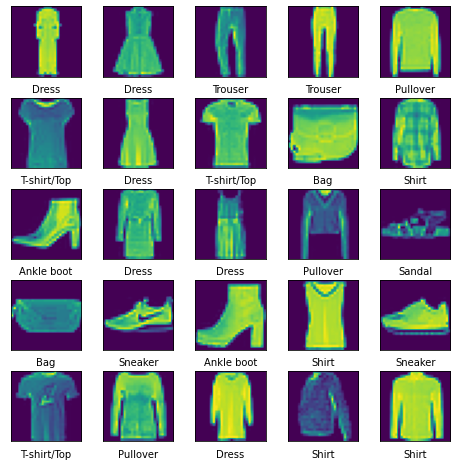

In [14]:
import matplotlib.pyplot as plt 

label_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.squeeze())
    plt.xlabel(label_names[label])
plt.subplots_adjust(hspace=0.3)
plt.show()

In [15]:
img.size()

torch.Size([1, 28, 28])

#### Fitting the Model

With the neural network architecture and data loaders in place, we can now focus on the process of training the model, also known as *fitting* the model to the data. The training process can be divided into two main components: the training loop and the validation loop.

**The training loop** is responsible for feeding the mini-batches of data to the model, computing the predictions and loss, and updating the model’s parameters using backpropagation and an optimization algorithm. This loop is typically run for a fixed number of epochs or until a certain stopping criterion is met.

On the other hand, **the validation loop** is used to evaluate the model’s performance on a separate validation dataset, which is not used for training. This helps monitor the model’s generalization performance and prevents overfitting to the training data.

In the following code, we implement a `Learner` class that encapsulates this logic and provides a convenient interface for fitting the model and monitoring its performance.

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

class Learner:
    """
    Learner class for training and evaluating a model.

    This class encapsulates the training and validation loops, as well as
    utility methods for prediction, exporting the model, and calculating
    accuracy.
    """

    def __init__(self, config, loaders):
        """
        Initialize the Learner.

        Args:
            config (LearnerConfig): Configuration for the Learner.
            loaders (dict): Dictionary of data loaders for training and testing.
        """
        self.model = config.model
        self.loaders = loaders
        self.optimizer = Optimizer(self.model.parameters(), config.lr)
        self.criterion = config.criterion
        self.epochs = config.epochs
        self.device = config.device
        self.labels = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-Boot']
        self.model.to(self.device)

    def train_epoch(self, epoch):
        """
        Train the model for one epoch.
        """
        epoch_loss = 0.0
        for x, y in self.loaders["train"]:
            x, y = x.to(self.device), y.to(self.device)
            batch_size = x.size(0)

            # Zero out the gradients - otherwise, they will accumulate.
            self.optimizer.zero_grad()
   
            # Forward pass, loss calculation, and backpropagation
            output = self.model(x)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item() * batch_size

        train_loss = epoch_loss / len(self.loaders['train'].dataset)
        return train_loss
    
    def valid_loss(self):
        """
        Calculate the validation loss.
        """
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in self.loaders["test"]:
                x, y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                val_loss += self.criterion(output, y).item() * y.size(0)
        val_loss /= len(self.loaders["test"].dataset)
        return val_loss

    def batch_accuracy(self, x, y):
        """
        Calculate the accuracy for a batch of inputs (x) and targets (y).
        """        
        _, preds = torch.max(x.data, 1)
        return (preds == y).sum().item() / x.size(0)

    def validate_epoch(self):
        """
        Evaluate the model on the test dataset after an epoch.
        """        
        accs = [self.batch_accuracy(self.model(x.to(self.device)), y.to(self.device))
                for x, y in self.loaders["test"]]
        return sum(accs) / len(accs)
            
    def fit(self):
        """
        Train the model for the specified number of epochs.
        """
        print('epoch\ttrain_loss\tval_loss\ttest_accuracy')
        for epoch in range(self.epochs):
            train_loss = self.train_epoch(epoch)
            valid_loss = self.valid_loss()
            batch_accuracy = self.validate_epoch()
            print(f'{epoch+1}\t{train_loss:.6f}\t{valid_loss:.6f}\t{batch_accuracy:.6f}')

        metrics = self.evaluate()
        return metrics
    
    def export(self, path):
        torch.save(self.model, path)
                            
    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for x, y in self.loaders["test"]:
                x, y = x.to(self.device), y.to(self.device)
                outputs = self.model(x)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        class_precision = precision_score(all_targets, all_preds, average=None)
        class_recall = recall_score(all_targets, all_preds, average=None)
        class_f1 = f1_score(all_targets, all_preds, average=None)

        metrics = {label: {"precision": prec, "recall": rec, "f1": f1}
                   for label, prec, rec, f1 in zip(self.labels, class_precision, class_recall, class_f1)}

        return metrics

In [17]:
learner = Learner(config, loaders)

In [18]:
metrics = learner.fit()

epoch	train_loss	val_loss	test_accuracy
1	1.065290	0.701128	0.739217
2	0.592905	0.560477	0.802316
3	0.510731	0.512957	0.818490
4	0.472870	0.485383	0.826178
5	0.449019	0.472154	0.831569
6	0.431612	0.453272	0.837959
7	0.416788	0.454649	0.837959
8	0.405032	0.449825	0.838059
9	0.394726	0.424190	0.848642
10	0.385351	0.433628	0.844249
11	0.377778	0.415856	0.852536
12	0.369839	0.431756	0.845347
13	0.363344	0.404523	0.855032
14	0.357174	0.399389	0.858327
15	0.351769	0.396196	0.859625
16	0.346010	0.395194	0.858327
17	0.340760	0.394818	0.859924
18	0.335763	0.390063	0.859325
19	0.331339	0.389222	0.860224
20	0.327408	0.398900	0.858127
21	0.322994	0.383155	0.862520
22	0.318720	0.381793	0.865016
23	0.314312	0.377744	0.863718
24	0.310974	0.370490	0.867312
25	0.306936	0.373222	0.868810


In [19]:
labels = ['T-shirt/Top', 'Trouser/Jeans', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-Boot']

# Determine the maximum label length for padding
max_label_len = max(len(label) for label in labels)

header = "Label".ljust(max_label_len + 2) + "Precision".ljust(12) + "Recall".ljust(12) + "F1-score"
print(header)
print("-" * len(header))

# Print metrics for each class
for label, metric in zip(labels, metrics.values()):
    row = label.ljust(max_label_len + 2) + \
        f"{metric['precision']:.6f}".ljust(12) + \
        f"{metric['recall']:.6f}".ljust(12) + \
        f"{metric['f1']:.6f}"
    print(row)

Label          Precision   Recall      F1-score
-----------------------------------------------
T-shirt/Top    0.824065    0.815000    0.819507
Trouser/Jeans  0.974671    0.962000    0.968294
Pullover       0.754911    0.807000    0.780087
Dress          0.889234    0.859000    0.873856
Coat           0.749101    0.833000    0.788826
Sandal         0.945491    0.954000    0.949726
Shirt          0.718097    0.619000    0.664876
Sneaker        0.926148    0.928000    0.927073
Bag            0.956349    0.964000    0.960159
Ankle-Boot     0.950803    0.947000    0.948898


--------

### Inference

After training the model, we can use it for inference, which involves making predictions on new data. The inference process is relatively straightforward but requires to transform real-world garment images to the format of the training dataset. To achieve this, we implement a PyTorch transformation.

#### From Model

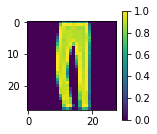

In [20]:
import torchvision.transforms as transforms

images, _ = next(iter(loaders['test']))
i = torch.randint(len(images), size=(1,)).item()
img = images[i]

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze())
plt.colorbar()
plt.show()

In [21]:
predictions = learner.model.predictions(img.to(device))
dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))

{'Trouser/Jeans': 0.9999685,
 'T-shirt/Top': 2.0114901e-05,
 'Dress': 5.410879e-06,
 'Pullover': 3.6691952e-06,
 'Coat': 1.8515707e-06,
 'Shirt': 1.895202e-07,
 'Bag': 1.7836999e-07,
 'Sneaker': 3.9207322e-08,
 'Sandal': 2.446767e-10,
 'Ankle-Boot': 5.493367e-12}

#### From Exported Model using a real Image

In [22]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize
        transforms.Lambda(lambda x: 1.0 - x),  # Invert colors
        transforms.Lambda(lambda x: x[0]),
        transforms.Lambda(lambda x: x.unsqueeze(0)),
    ]
)

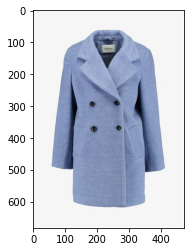

In [26]:
img = Image.open('assets/fashion/coat.png')
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.show()

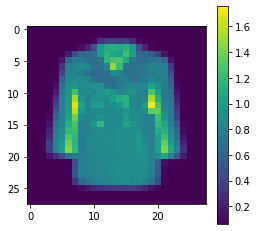

In [27]:
img = transform(img)
plt.figure(figsize=(4, 4))
plt.imshow(img.squeeze())
plt.colorbar()
plt.show()

In [28]:
learner.export('fashion.classifier.base.v0.pt')
model = torch.load('fashion.classifier.base.v0.pt')

predictions = model.predictions(img.to(device))
dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))

{'Coat': 0.85753894,
 'Pullover': 0.08604192,
 'Shirt': 0.029012311,
 'Bag': 0.026708055,
 'T-shirt/Top': 0.00060888083,
 'Dress': 7.7936886e-05,
 'Trouser/Jeans': 1.1995183e-05,
 'Sandal': 3.1396417e-09,
 'Sneaker': 1.028194e-10,
 'Ankle-Boot': 1.9806512e-11}